    Region Time of Day  Number of Vehicles Weather Condition  CO Level  \
0     West       Night               936.0             Clear      4.37   
1  Central       Night               477.0             Clear       NaN   
2     East         NaN              1378.0            Cloudy      7.76   
3  Central       Night              1945.0             Rainy      5.95   
4      NaN       Night               366.0               NaN      9.58   

   NO2 Level  PM2.5 Level  Proximity to Public Transport (km)  Pollution Level  
0     115.87        89.63                                6.35           401.21  
1      57.25          NaN                                5.24           140.53  
2     124.34       107.60                                0.61            86.03  
3     149.64        64.76                                2.41              NaN  
4      23.90        11.23                                 NaN            54.49  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 

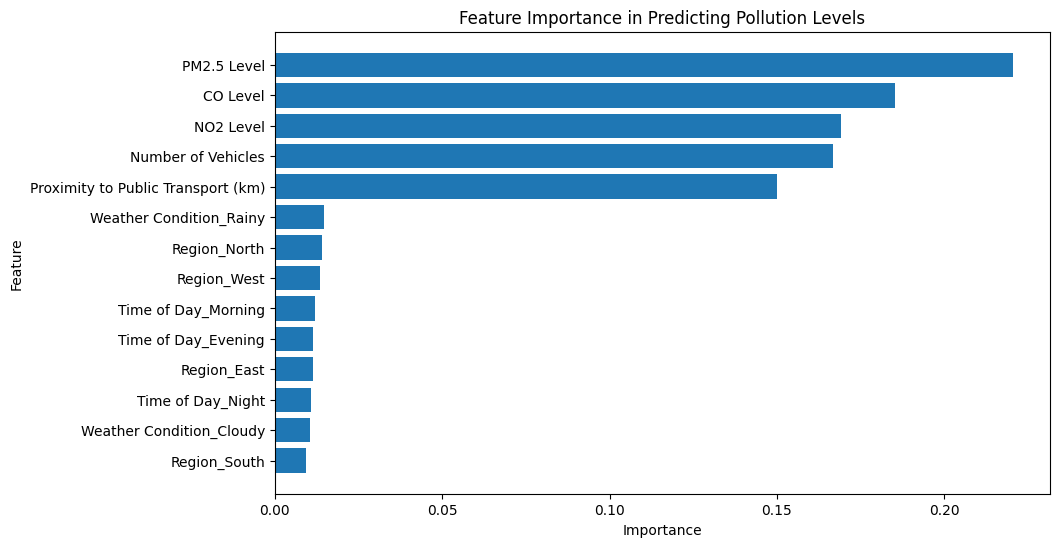

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Load dataset (assuming the dataset is saved as 'traffic_pollution_data.csv')
file_path = 'traffic_pollution_data.csv'  # Update with the actual file path
data = pd.read_excel('/content/chennai_traffic_pollution_data.xlsx')

# Inspect data
print(data.head())
print(data.info())

# Data Preprocessing
# 1. Handle missing values
# Handle missing values separately for numeric and categorical columns
numeric_cols = data.select_dtypes(include=['float64', 'int64']).columns
categorical_cols = data.select_dtypes(include=['object']).columns

# Fill missing numeric values with the median
data[numeric_cols] = data[numeric_cols].fillna(data[numeric_cols].median())

# Fill missing categorical values with the most frequent value (mode)
data[categorical_cols] = data[categorical_cols].fillna(data[categorical_cols].mode().iloc[0])


# 2. Separate features and target variable
X = data.drop(['Pollution Level'], axis=1)
y = data['Pollution Level']

# 3. Identify categorical and numerical columns
categorical_cols = ['Region', 'Time of Day', 'Weather Condition']
numerical_cols = [col for col in X.columns if col not in categorical_cols]

# 4. Preprocessing for numerical data: scaling
numerical_transformer = StandardScaler()

# 5. Preprocessing for categorical data: one-hot encoding
categorical_transformer = OneHotEncoder(drop='first', handle_unknown='ignore')

# 6. Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

# 7. Create a pipeline for Random Forest Regressor
rf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(random_state=42))
])

# Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define hyperparameter grid for Random Forest
param_grid = {
    'regressor__n_estimators': [50, 100, 200],
    'regressor__max_depth': [10, 20, None],
    'regressor__min_samples_split': [2, 5, 10],
    'regressor__min_samples_leaf': [1, 2, 4]
}

# Hyperparameter tuning with GridSearchCV
grid_search = GridSearchCV(rf_pipeline, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Best parameters from Grid Search
best_params = grid_search.best_params_
print("Best parameters:", best_params)

# Predict on the test set with the best estimator
y_pred = grid_search.best_estimator_.predict(X_test)

# Evaluate model performance
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error:", mse)
print("Mean Absolute Error:", mae)
print("R2 Score:", r2)

# Feature Importance
best_model = grid_search.best_estimator_.named_steps['regressor']
feature_importance = best_model.feature_importances_
feature_names = numerical_cols + list(grid_search.best_estimator_.named_steps['preprocessor'].transformers_[1][1].get_feature_names_out())

importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance}).sort_values(by='Importance', ascending=False)
print(importance_df)

# Visualization of feature importance
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance in Predicting Pollution Levels')
plt.gca().invert_yaxis()
plt.show()
